## Git update

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
!ssh-keygen -R github.com
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

Cannot stat /root/.ssh/known_hosts: No such file or directory
/bin/bash: line 1: /root/.ssh/known_hosts: No such file or directory


In [45]:
!cd drive/MyDrive/ && git clone git@github.com:Ruizhe0723/Mini-CV-Project.git

Cloning into 'Mini-CV-Project'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
!cd drive/MyDrive/Mini-CV-Project && git init

Reinitialized existing Git repository in /content/drive/MyDrive/Mini-CV-Project/.git/


In [42]:
!cd drive/MyDrive/Mini-CV-Project && git config --global user.email "1900011042@pku.edu.cn" && git config --global user.name "Ruizhe0723"

In [37]:
!cd drive/MyDrive/Mini-CV-Project && git add SAM-Sherrie.ipynb
!cd drive/MyDrive/Mini-CV-Project && git commit -m "initial commit"

[main (root-commit) e8da950] initial commit
 1 file changed, 1 insertion(+)
 create mode 100644 SAM-Sherrie.ipynb


In [43]:
!cd drive/MyDrive/Mini-CV-Project && git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


## Load Data

In [ ]:
!pip install datasets pillow matplotlib
!pip install supervision
!pip install numpy

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load the dataset
dataset = load_dataset("danielz01/landmarks")

# Access different splits if available
train_dataset = load_dataset("danielz01/landmarks", split="train")

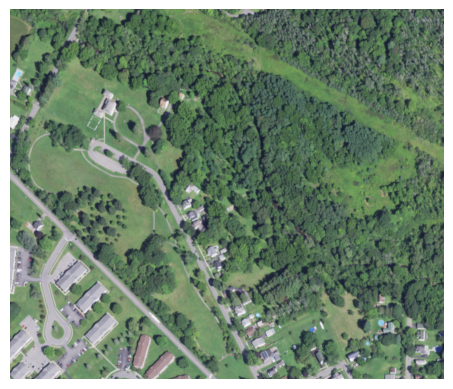

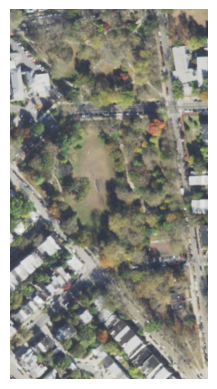

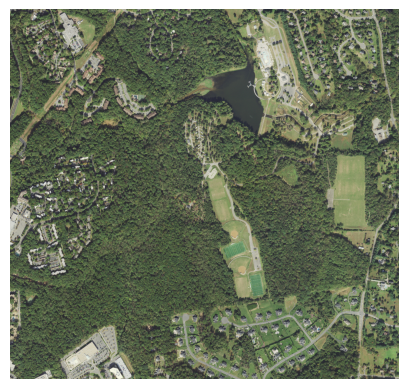

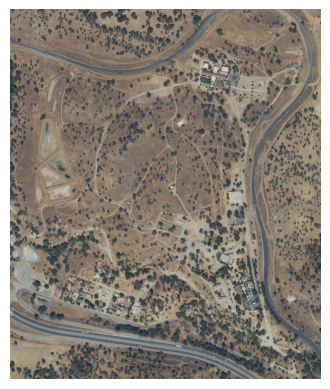

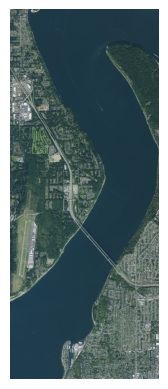

In [ ]:
# Print the first few examples
for i in range(5):  # Adjust the range as needed
    image = train_dataset[i]['image']
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Aug 19 19:26:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0              26W /  70W |   2679MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


### Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv
import numpy as np

# image_bgr = cv2.imread(IMAGE_PATH)
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image = np.array(train_dataset[0]['image'])

# image_bgr = cv2.imread(image)
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

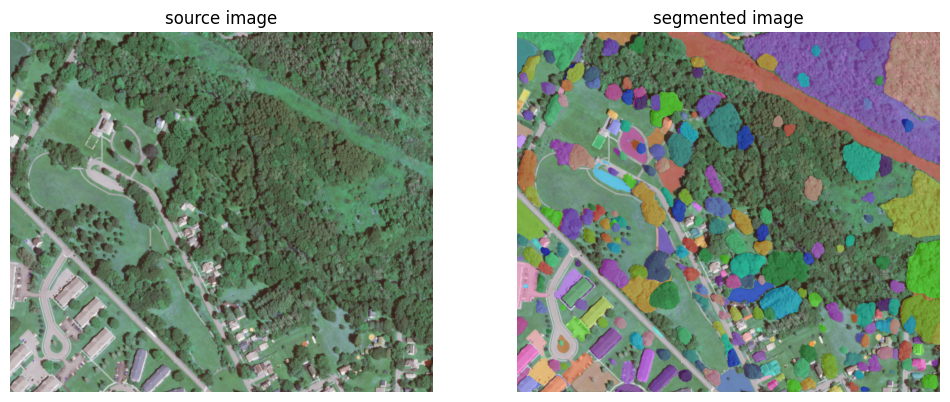

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

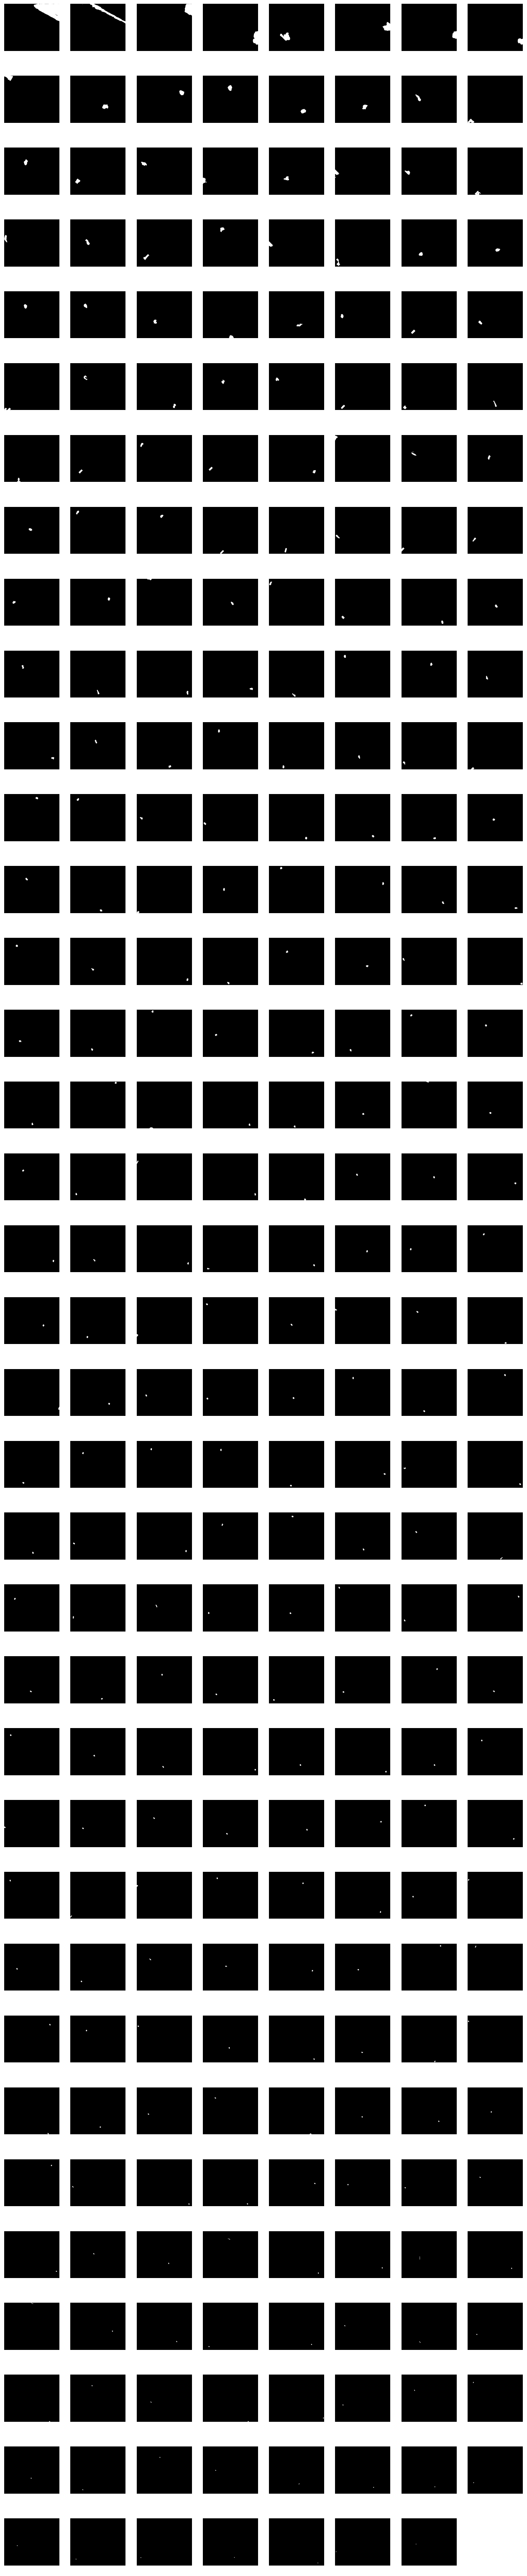

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(int(len(masks) / 8)+1, 8),
    size=(16, 80)
)